In [74]:
###############################################################################################################################################################
#----------------------------------------------------------------------SETUP-----------------------------------------------------------------------------------
###############################################################################################################################################################

In [ ]:
#PySpark data handeling imports
from pyspark.sql import SparkSession, Row
from pyspark.ml.image import ImageSchema
from pyspark.sql.functions import regexp_replace, when, col
from pyspark.sql import functions as F

#Tensorflow model imports
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

#SKLearn data handeling imports
from sklearn.model_selection import train_test_split

#Data Visualisation imports
import seaborn as sns
import matplotlib.pyplot as plt

import sys
import numpy as np
import os
from glob import glob
from PIL import Image
import random

In [76]:
#Enviomental variables

#Solves the following envioment error:
#   "Python in worker has different version 3.10 than that in driver 3.11, PySpark cannot run with different minor versions. 
#       Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set."
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

#Create new spark session
spark = SparkSession.builder \
    .appName("ImageProcessing") .getOrCreate()
    # .config("spark.hadoop.io.native.lib.available", "false") \
    # .config("spark.pyspark.python", os.environ['PYSPARK_PYTHON']) \
    # .config("spark.pyspark.driver.python", os.environ['PYSPARK_DRIVER_PYTHON']) \
    

In [77]:
###############################################################################################################################################################
#----------------------------------------------------------------------DATA LOADING & PREPROCESSING------------------------------------------------------------
###############################################################################################################################################################

In [78]:
#Get image attributes from CSV using spark
labels_df = spark.read.csv("list_attr_celeba.csv", header=True, inferSchema=True)
labels_df = labels_df.select("image_id", "Male", "Smiling")
labels_df = labels_df.withColumn("image_id", regexp_replace("image_id", ".jpg", ""))

#Normalise smiling label to be binery and not -1 and 1
smiling_norm = when(col("Smiling") >= 0, 1).otherwise(0)
labels_df = labels_df.withColumn("Smiling", smiling_norm)

#Check
labels_df.printSchema()
labels_df.show(5)

root
 |-- image_id: string (nullable = true)
 |-- Male: integer (nullable = true)
 |-- Smiling: integer (nullable = false)

+--------+----+-------+
|image_id|Male|Smiling|
+--------+----+-------+
|  000001|  -1|      1|
|  000002|  -1|      1|
|  000003|   1|      0|
|  000004|  -1|      0|
|  000005|  -1|      0|
+--------+----+-------+
only showing top 5 rows



In [79]:
#Get image file paths
image_dir = "images"
image_files = [(filename.split('.')[0], os.path.join(image_dir, filename)) for filename in os.listdir(image_dir) if filename.endswith('.jpg')]

#Get only a certain number to reduce computational cost and time
image_files = image_files[:10000]

#Convert list to spark dataframe
images_df = spark.createDataFrame([Row(image_id=img[0], image_path=img[1]) for img in image_files])

#Check
images_df.printSchema()
images_df.show(5)

root
 |-- image_id: string (nullable = true)
 |-- image_path: string (nullable = true)

+--------+-----------------+
|image_id|       image_path|
+--------+-----------------+
|  000001|images\000001.jpg|
|  000002|images\000002.jpg|
|  000003|images\000003.jpg|
|  000004|images\000004.jpg|
|  000005|images\000005.jpg|
+--------+-----------------+
only showing top 5 rows



In [80]:
#Merge spark dataframes together to apply the correct label to each image
labeled_images_df = images_df.join(labels_df, on="image_id")
labeled_images_df = labeled_images_df.select("image_path", "Smiling")
labeled_images_df = labeled_images_df.dropna()
labeled_images_df.show(5)

+-----------------+-------+
|       image_path|Smiling|
+-----------------+-------+
|images\000001.jpg|      1|
|images\000002.jpg|      1|
|images\000003.jpg|      0|
|images\000004.jpg|      0|
|images\000005.jpg|      0|
+-----------------+-------+
only showing top 5 rows



In [ ]:
###############################################################################################################################################################
#----------------------------------------------------------------------EXPLORATORY DATA ANALYSIS---------------------------------------------------------------
###############################################################################################################################################################

In [82]:
#Create copy of the dataframe using pandas 
#Pandas is used for easier interaction and graphing
labeled_images_pd = labeled_images_df.toPandas()

Not Smiling & Smiling counts:
Smiling
0    5178
1    4822
Name: count, dtype: int64


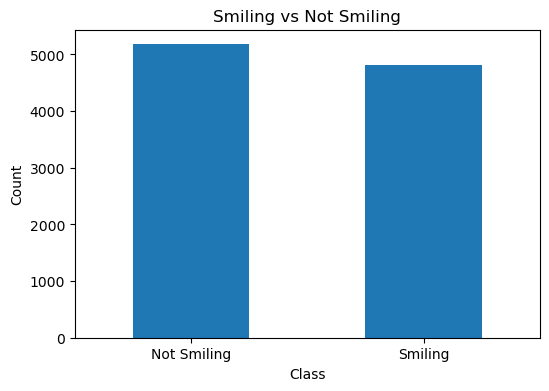

In [83]:
#Output class label data distribution
smiling_counts = labeled_images_pd['Smiling'].value_counts()
print(f"Not Smiling & Smiling counts:\n{smiling_counts}")

plt.figure(figsize=(6, 4))
smiling_counts.plot(kind='bar', title="Smiling vs Not Smiling")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks([0, 1], ['Not Smiling', 'Smiling'], rotation=0)
plt.show()

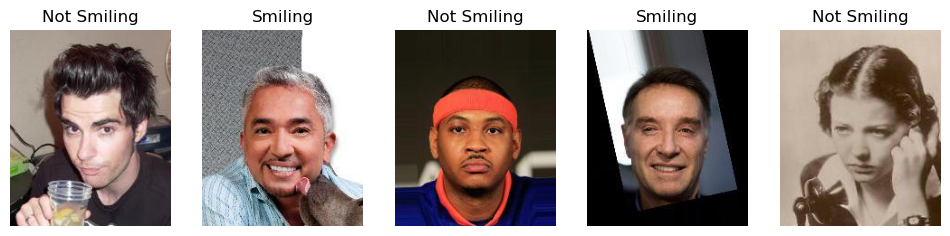

In [86]:
#Show random images with their labels
sample_images = random.sample(list(labeled_images_pd[['image_path', 'Smiling']].values), 5)

plt.figure(figsize=(12, 6))

for i, (img_path, classlabel) in enumerate(sample_images):
    if classlabel == 0:
        label = 'Not Smiling'
    else:
        label = 'Smiling'

    img = Image.open(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"{label}")
    plt.axis('off')

plt.show()

In [67]:
###############################################################################################################################################################
#----------------------------------------------------------------------CREATING THE PIPELINES------------------------------------------------------------------
###############################################################################################################################################################

In [ ]:
###############################################################################################################################################################
#----------------------------------------------------------------------APPLYING THE PIPELINES------------------------------------------------------------------
###############################################################################################################################################################

In [73]:
###############################################################################################################################################################
#----------------------------------------------------------------------USER INPUT------------------------------------------------------------------------------
###############################################################################################################################################################